In [2]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging
import pickle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

from theory.models.carlosha.ha import get_current_ha
importlib.reload(sys.modules["theory.modles.carlosha.ha"])

from tien_gordon import get_tien_gordon_pat
importlib.reload(sys.modules["tien_gordon"])

from theory.carlosfcs.fcs import get_current_fcs
importlib.reload(sys.modules["theory.carlosfcs.fcs"])

from theory.dynes.dynes import get_current_dynes
importlib.reload(sys.modules["theory.dynes.dynes"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from scipy.constants import e, h
G_0 = 2 * e**2 / h


KeyError: 'theory.modles.carlosha.ha'

In [3]:
from theory.models import dynes_jnp

In [4]:
dynes_jnp.get_current_dynes(np.linspace(-1,1, 10001))

array([-37.265095, -37.257065, -37.249046, ...,  37.249046,  37.257065,
        37.265095], shape=(10001,), dtype=float32)

In [12]:
# Parameter
voltage_bias_mV = np.linspace(-1.2, 1.2, 1201)
voltage_nu_V = np.linspace(0, 1.2e-3, 301, dtype='float64')

transmission = .8
temperature_K = 0 # K
dynes_parameter_eV = 0 # eV
energy_gap_eV = 189e-6 # eV
nu = 19.3e9 # Hz

pincode = np.array([0.80, 0.62, 0.33, 0.25, 0.01])

# Single Channel (S-I-S)

### Photon-Assisted Tunneling (PAT)

$$
I_\mathrm{PAT}(V_0, V_\nu) = \sum_{n=-N}^N J_n^2\left(\frac{eV_\nu}{h\nu}\right) \cdot I_{0}\left(\frac{eV_0}{\Delta} - n\cdot\frac{h\nu}{\Delta} \right)
$$

### Dynes Model

In [16]:
# get current from Dynes Model
from theory.dynes.dynes import get_current_dynes
importlib.reload(sys.modules["theory.dynes.dynes"])

current_dynes_nA = get_current_dynes(
    voltage_mV=voltage_bias_mV, 
    energy_gap_eV=energy_gap_eV,
    transmission=transmission, 
    temperature_K=temperature_K, 
    dynes_parameter_eV=dynes_parameter_eV, 
    )
conductance_dynes = np.gradient(current_dynes_nA, voltage_bias_mV) * 1e-6 / G_0

yea


Text(0.5, 0, '')

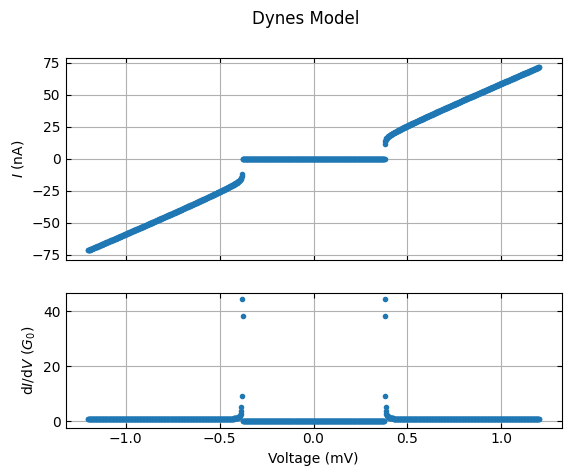

In [17]:
# show currents and conductance from Dynes Model
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle('Dynes Model')
ax0.plot(voltage_bias_mV, current_dynes_nA, '.')
ax1.plot(voltage_bias_mV, conductance_dynes, '.')
ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (mV)")

ax0.sharex(ax1)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [19]:
# get current from Tien Gordon Modell and Dynes Model
from tien_gordon import get_tien_gordon_pat
importlib.reload(sys.modules["tien_gordon"])

current_dynes_tg_pat = get_tien_gordon_pat(
    voltage_nu_V=voltage_nu_V,
    voltage_bias_V=voltage_bias_mV*1e-3,
    current_0=current_dynes_nA*1e-9,
    energy_gap_eV=energy_gap_eV,
    nu = nu)
conductance_dynes_tg_pat = np.gradient(current_dynes_tg_pat, voltage_bias_mV*1e-3, axis=1) / G_0

Text(0.5, 0, '$eV_0$ ($\\Delta$)')

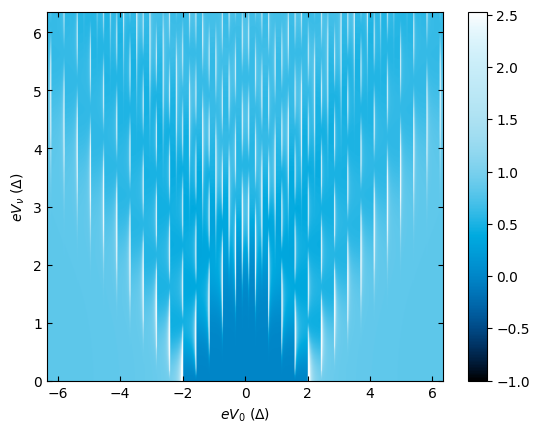

In [20]:
# show conductance from Tien Gordon Modell and Dynes Model
%matplotlib inline
z = conductance_dynes_tg_pat
x = voltage_bias_mV *1e-3 / energy_gap_eV
y = voltage_nu_V / energy_gap_eV

dx, dy = x[-1]-x[-2], y[-1]-y[-2]
ext = (x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2)
clim = (np.nanmean(z)-2*np.nanstd(z), np.nanmean(z)+2*np.nanstd(z))

fig, ax = plt.subplots()
im = ax.imshow(
    z, 
    aspect='auto', 
    origin='lower', 
    clim=clim, 
    extent=ext, 
    interpolation=None,
    cmap=cmap(bad="grey"),
    )
ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )
cbar = fig.colorbar(im)
ax.set_ylabel(r'$eV_\nu$ ($\Delta$)')
ax.set_xlabel(r'$eV_0$ ($\Delta$)')

### Hamiltonian Approach

In [96]:
# get current from Hamiltonian Approach
from theory.carlosha.ha import get_current_ha
importlib.reload(sys.modules["theory.carlosha.ha"])

current_ha_nA = get_current_ha(
    voltage_mV=voltage_bias_mV, 
    energy_gap_V=energy_gap_eV,
    transmission=transmission, 
    temperature_K=temperature_K, 
    dynes_parameter_V=dynes_parameter_V, 
    )
conductance_ha = np.gradient(current_ha_nA, voltage_bias_mV) * 1e-6 / G_0

cached values: 0/601


IV simulations: 100%|██████████| 601/601 [00:05<00:00, 118.71sim/s]


Text(0.5, 0, '')

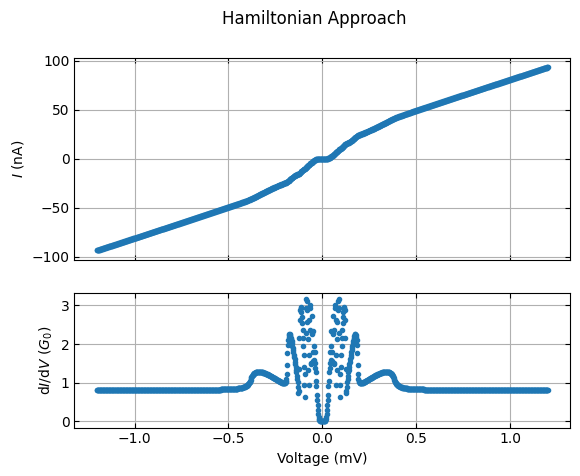

: 

In [ ]:
# show currents and conductance from Hamiltonian Approach
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle('Hamiltonian Approach')
ax0.plot(voltage_bias_mV, current_ha_nA, '.')
ax1.plot(voltage_bias_mV, conductance_ha, '.')
ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (mV)")

ax0.sharex(ax1)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [82]:
# get current from Tien Gordon Modell and Hamiltonian Approach
from tien_gordon import get_tien_gordon_pat
importlib.reload(sys.modules["tien_gordon"])

current_ha_tg_pat = get_tien_gordon_pat(
    voltage_nu_V=voltage_nu_V,
    voltage_bias_V=voltage_bias_mV*1e-3,
    current_0=current_ha_nA*1e-9,
    energy_gap_eV=energy_gap_eV,
    nu = nu)
conductance_ha_tg_pat = np.gradient(current_ha_tg_pat, voltage_bias_mV*1e-3, axis=1) / G_0

Text(0.5, 0, '$eV_0$ ($\\Delta$)')

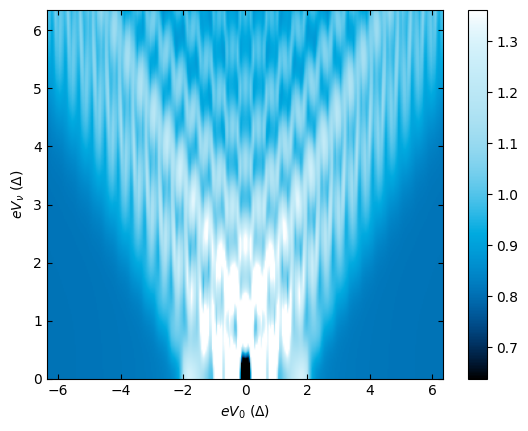

In [83]:
# show conductance from Tien Gordon Modell and Hamiltonian Approach
%matplotlib inline
z = conductance_ha_tg_pat
x = voltage_bias_mV *1e-3 / energy_gap_eV
y = voltage_nu_V / energy_gap_eV

dx, dy = x[-1]-x[-2], y[-1]-y[-2]
ext = (x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2)
clim = (np.nanmean(z)-2*np.nanstd(z), np.nanmean(z)+2*np.nanstd(z))

fig, ax = plt.subplots()
im = ax.imshow(
    z, 
    aspect='auto', 
    origin='lower', 
    clim=clim, 
    extent=ext, 
    interpolation=None,
    cmap=cmap(bad="grey"),
    )
ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )
cbar = fig.colorbar(im)
ax.set_ylabel(r'$eV_\nu$ ($\Delta$)')
ax.set_xlabel(r'$eV_0$ ($\Delta$)')

### Photon-Assisted Multiple Andreev Reflection (PAMAR)

$$
I_\mathrm{PAMAR}(V_0, V_\nu) = \sum_{m=1}^M \sum_{n=-N}^N J_n^2\left(m \cdot \frac{eV_\nu}{h\nu}\right) \cdot I_{0,m}\left(\frac{eV_0}{\Delta} - \frac{n}{m}\cdot\frac{h\nu}{\Delta} \right)
$$

In [84]:
# get current from Full Counting Statistics
from theory.carlosfcs.fcs import get_current_fcs
importlib.reload(sys.modules["theory.carlosfcs.fcs"])

current_fcs_nA = get_current_fcs(
    voltage_mV=voltage_bias_mV, 
    temperature_K=temperature_K, 
    transmission=transmission, 
    dynes_parameter_V=dynes_parameter_V, 
    energy_gap_V=energy_gap_eV,
    )
conductance_fcs = np.gradient(current_fcs_nA, voltage_bias_mV, axis=0) * 1e-6 / G_0

cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:40<00:00,  3.77sim/s]


Text(0.5, 0, '')

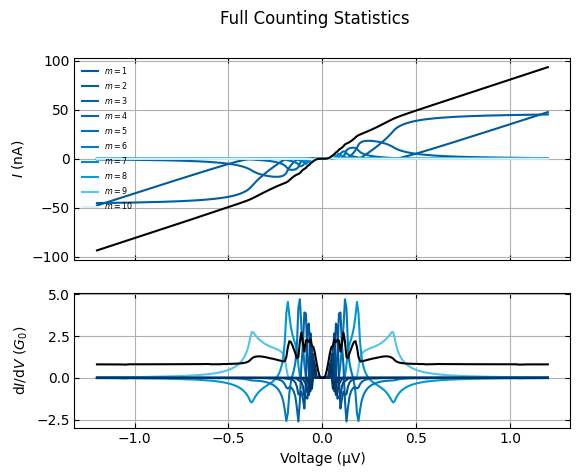

In [86]:
# show currents and conductance from Full Counting Statistics
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle('Full Counting Statistics')

for i in range(1, current_fcs_nA.shape[1]):
    ax0.plot(voltage_bias_mV, current_fcs_nA[:,i], color=cmap()(.8/(11-i)+.1), label=f"$m = {i}$")
    ax1.plot(voltage_bias_mV, conductance_fcs[:,i], color=cmap()(1/i))
ax0.plot(voltage_bias_mV, current_fcs_nA[:,0], 'k')
ax1.plot(voltage_bias_mV, conductance_fcs[:,0], 'k')

ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (µV)")

ax0.sharex(ax1)
ax0.legend(fontsize="xx-small", frameon=False)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [87]:
# get current from modified Tien Gordon Modell and Full Countings Statistics
from tien_gordon import get_tien_gordon_pamar
importlib.reload(sys.modules["tien_gordon"])

current_fcs_tg_pamar = get_tien_gordon_pamar(
    voltage_nu_V=voltage_nu_V,
    voltage_bias_V=voltage_bias_mV*1e-3,
    current_0=current_fcs_nA*1e-9,
    energy_gap_eV=energy_gap_eV,
    nu = nu)
conductance_fcs_tg_pamar = np.gradient(current_fcs_tg_pamar, voltage_bias_mV*1e-3, axis=1) / G_0

PAMAR total:   0%|          | 0/18009 [00:00<?, ?it/s]

PAMAR total: 100%|██████████| 18009/18009 [00:05<00:00, 3286.77it/s]


Text(0.5, 0, '$eV_0$ ($\\Delta$)')

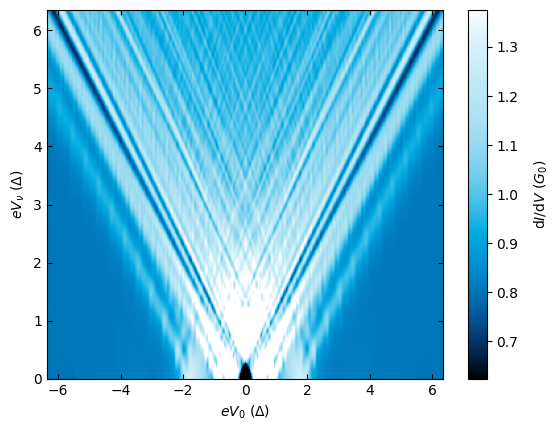

In [88]:
# show conductance from modified Tien Gordon Modell and Full Countings Statistics
%matplotlib inline
z = conductance_fcs_tg_pamar
x = voltage_bias_mV * 1e-3 / energy_gap_eV
y = voltage_nu_V / energy_gap_eV

dx, dy = x[-1]-x[-2], y[-1]-y[-2]
ext = (x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2)
clim = (np.nanmean(z)-2*np.nanstd(z), np.nanmean(z)+2*np.nanstd(z))

fig, ax = plt.subplots()
im = ax.imshow(
    z, 
    aspect='auto', 
    origin='lower', 
    clim=clim, 
    extent=ext, 
    interpolation=None,
    cmap=cmap(bad="grey"),
    )
ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )
cbar = fig.colorbar(im)
cbar.set_label(r'd$I/$d$V$ ($G_0$)', labelpad=10, loc="center")
ax.set_ylabel(r'$eV_\nu$ ($\Delta$)')
ax.set_xlabel(r'$eV_0$ ($\Delta$)')

# Multi-channel (S-I-S)

### Photon-Assisted Tunneling (PAT)

In [89]:
# get all currents from Hamiltonian Approach

from theory.carlosha.ha import get_current_ha
importlib.reload(sys.modules["theory.carlosha.ha"])


all_current_ha_nA = np.full((pincode.shape[0], voltage_bias_mV.shape[0]), np.nan)
for i, tau in enumerate(pincode):
    all_current_ha_nA[i] = get_current_ha(
        voltage_mV=voltage_bias_mV, 
        temperature_K=temperature_K, 
        transmission=tau, 
        dynes_parameter_V=dynes_parameter_V, 
        energy_gap_V=energy_gap_eV,
        )
all_conductance_ha = np.gradient(all_current_ha_nA, voltage_bias_mV, axis=1) * 1e-6 / G_0

cached values: 151/151
cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:01<00:00, 123.28sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:01<00:00, 128.10sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:01<00:00, 128.30sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:00<00:00, 234.38sim/s]


Text(0.5, 0, '')

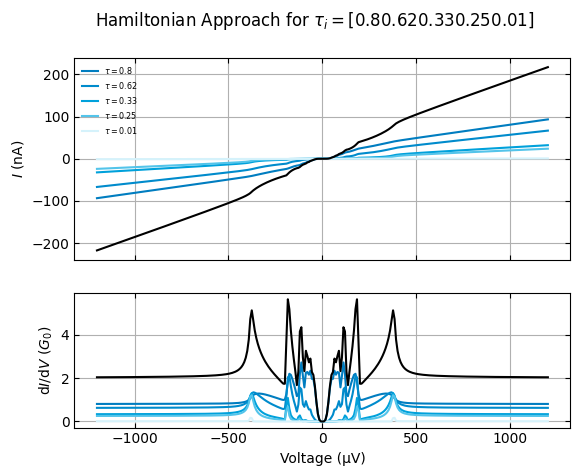

In [90]:
# show all currents and conductance from Hamiltonian Approach
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle(rf'Hamiltonian Approach for $\tau_i = {pincode}$')
for i, tau in enumerate(pincode):
    ax0.plot(voltage_bias_mV*1e3, all_current_ha_nA[i,:], color=cmap()(.8/(pincode.shape[0]-i)+.1), label=rf'$\tau = {tau}$')
    ax1.plot(voltage_bias_mV*1e3, all_conductance_ha[i,:], color=cmap()(.8/(pincode.shape[0]-i)+.1), )
ax0.plot(voltage_bias_mV*1e3, np.sum(all_current_ha_nA, axis=0), 'k')
ax1.plot(voltage_bias_mV*1e3, np.sum(all_conductance_ha, axis=0), 'k')

ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (µV)")

ax0.sharex(ax1)
ax0.legend(fontsize="xx-small", frameon=False)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [91]:
# get current from Tien Gordon Modell and Hamiltonian Approach
from tien_gordon import get_tien_gordon_pat
importlib.reload(sys.modules["tien_gordon"])

all_current_ha_tg_pat = np.full((pincode.shape[0], voltage_nu_V.shape[0], voltage_bias_mV.shape[0]), np.nan)

for i, tau in enumerate(pincode):
    all_current_ha_tg_pat[i,:,:] = get_tien_gordon_pat(
        voltage_nu_V=voltage_nu_V,
        voltage_bias_V=voltage_bias_mV*1e-3,
        current_0=all_current_ha_nA[i,:]*1e-9,
        energy_gap_eV=energy_gap_eV,
        nu = nu)
    all_conductance_ha_tg_pat = np.gradient(all_current_ha_tg_pat, voltage_bias_mV*1e-3, axis=2) / G_0

Text(0.5, 0, '$eV_0$ ($\\Delta$)')

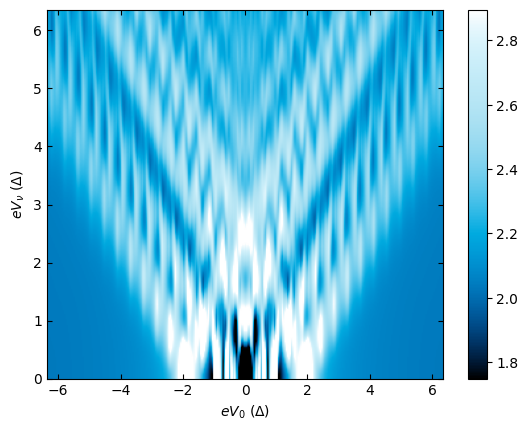

In [92]:
# show conductance from Tien Gordon Modell and Hamiltonian Approach
%matplotlib inline
z = np.sum(all_conductance_ha_tg_pat, axis=0)
x = voltage_bias_mV * 1e-3 / energy_gap_eV
y = voltage_nu_V / energy_gap_eV

dx, dy = x[-1]-x[-2], y[-1]-y[-2]
ext = (x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2)
clim = (np.nanmean(z)-2*np.nanstd(z), np.nanmean(z)+2*np.nanstd(z))

fig, ax = plt.subplots()
im = ax.imshow(
    z, 
    aspect='auto', 
    origin='lower', 
    clim=clim, 
    extent=ext, 
    interpolation=None,
    cmap=cmap(bad="grey"),
    )
ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )
cbar = fig.colorbar(im)
ax.set_ylabel(r'$eV_\nu$ ($\Delta$)')
ax.set_xlabel(r'$eV_0$ ($\Delta$)')

### Photon-Assisted Multiple Andreev Reflection

In [93]:
# get all currents from Full Counting Statistics 
from theory.carlosfcs.fcs import get_current_fcs
importlib.reload(sys.modules["theory.carlosfcs.fcs"])

all_currents_fcs_nA = np.full((pincode.shape[0], voltage_bias_mV.shape[0], 11), np.nan)
for i, tau in enumerate(pincode):
    all_currents_fcs_nA[i,:,:] = get_current_fcs(
        voltage_mV=voltage_bias_mV, 
        energy_gap_V=energy_gap_eV,
        temperature_K=temperature_K, 
        transmission=tau, 
        dynes_parameter_V=dynes_parameter_V, 
        )
all_conductances_fcs = np.gradient(all_currents_fcs_nA, voltage_bias_mV, axis=1) * 1e-6 / G_0

cached values: 151/151
cached values: 0/151


IV simulations: 100%|██████████| 151/151 [00:42<00:00,  3.55sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [01:04<00:00,  2.36sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [01:27<00:00,  1.72sim/s]


cached values: 0/151


IV simulations: 100%|██████████| 151/151 [01:36<00:00,  1.56sim/s]


Text(0.5, 0, '')

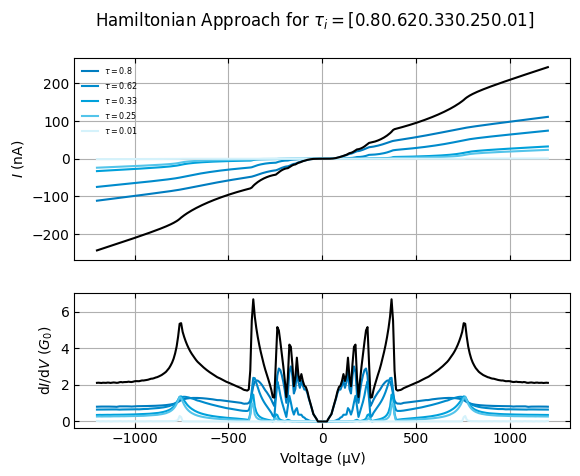

In [65]:
# show all currents and conductance from Full Counting Statistics
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle(rf'Hamiltonian Approach for $\tau_i = {pincode}$')
for i, tau in enumerate(pincode):
    ax0.plot(voltage_bias_mV*1e3, all_currents_fcs_nA[i,:,0], color=cmap()(.8/(pincode.shape[0]-i)+.1), label=rf'$\tau = {tau}$')
    ax1.plot(voltage_bias_mV*1e3, all_conductances_fcs[i,:,0], color=cmap()(.8/(pincode.shape[0]-i)+.1), )
ax0.plot(voltage_bias_mV*1e3, np.sum(all_currents_fcs_nA[:,:,0], axis=0), 'k')
ax1.plot(voltage_bias_mV*1e3, np.sum(all_conductances_fcs[:,:,0], axis=0), 'k')

ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (µV)")

ax0.sharex(ax1)
ax0.legend(fontsize="xx-small", frameon=False)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [67]:
# get current from modified Tien Gordon Modell, Full Countings Statistics and all tau
from tien_gordon import get_tien_gordon_pamar
importlib.reload(sys.modules["tien_gordon"])

all_current_fcs_tg_pamar = np.full((pincode.shape[0], voltage_nu_V.shape[0], voltage_bias_mV.shape[0]), np.nan)

for i, tau in enumerate(pincode):
    all_current_fcs_tg_pamar[i,:,:] = get_tien_gordon_pamar(
        voltage_nu_V=voltage_nu_V,
        voltage_bias_V=voltage_bias_mV*1e-3,
        current_0=all_currents_fcs_nA[i,:]*1e-9,
        energy_gap_eV=energy_gap_eV,
        nu = nu)
all_conductance_fcs_tg_pamar = np.gradient(all_current_fcs_tg_pamar, voltage_bias_mV * 1e-3, axis=2) / G_0

PAMAR total: 100%|██████████| 18009/18009 [00:07<00:00, 2327.45it/s]


Text(0.5, 0, '$eV_0$ ($\\Delta$)')

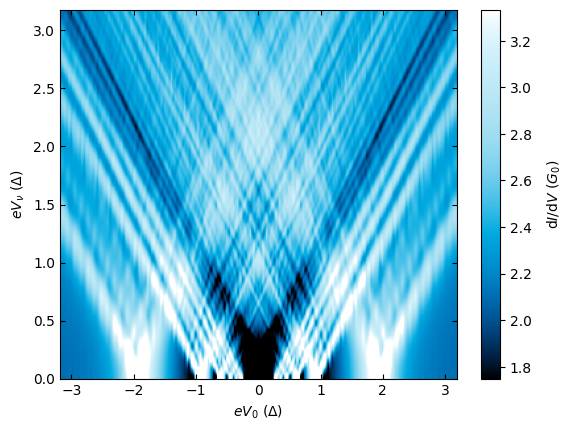

In [69]:
# show conductance from modified Tien Gordon Modell and Full Countings Statistics
%matplotlib inline
z = np.sum(all_conductance_fcs_tg_pamar, axis=0)
x = voltage_bias_mV * 1e-3 / energy_gap_eV
y = voltage_nu_V / energy_gap_eV

dx, dy = x[-1]-x[-2], y[-1]-y[-2]
ext = (x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2)
clim = (np.nanmean(z)-2*np.nanstd(z), np.nanmean(z)+2*np.nanstd(z))

fig, ax = plt.subplots()
im = ax.imshow(
    z, 
    aspect='auto', 
    origin='lower', 
    clim=clim, 
    extent=ext, 
    interpolation=None,
    cmap=cmap(bad="grey"),
    )
ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )
cbar = fig.colorbar(im)
cbar.set_label(r'd$I/$d$V$ ($G_0$)', labelpad=10, loc="center")
ax.set_ylabel(r'$eV_\nu$ ($\Delta$)')
ax.set_xlabel(r'$eV_0$ ($\Delta$)')